<a href="https://colab.research.google.com/github/marinebon/HackingLimno2025/blob/main/03_sdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching Occurrence Data from pyobis



In [1]:
!pip install pyobis  rasterio pandas geopandas matplotlib  requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 38.3 MB/s eta 0:00:00


Importing libraries

In [2]:
from pyobis import occurrences
import pandas as pd
from typing import List, Dict, Optional, Tuple
from datetime import datetime

Matplotlib for colab

In [3]:
%matplotlib inline

mount google drive for saving result

In [4]:
from google.colab import drive
drive.mount('/content/drive')


import os
project_dir = '/content/drive/MyDrive/GSoC_SDM_Project'
if not os.path.exists(project_dir):
    os.makedirs(project_dir)

Mounted at /content/drive


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install rasterio
!pip install xarray
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.2 MB/s eta 0:00:00


In [7]:
import rasterio
import xarray as xr
import numpy as np
from typing import Union, List, Tuple, Optional, Dict

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings

SDM Class for Marine species


In [9]:
class MarineSpeciesDistributionModel:
    """
    A Species Distribution Model for marine species using One-Class SVM
    Similar to the scikit-learn species distribution example but adapted for marine data
    """

    def __init__(self, nu=0.1, kernel='rbf', gamma=0.5):
        """
        Initialize the SDM model

        Parameters:
        -----------
        nu : float, default=0.1
            An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors
        kernel : str, default='rbf'
            Kernel type for SVM
        gamma : float, default=0.5
            Kernel coefficient for 'rbf'
        """
        self.nu = nu
        self.kernel = kernel
        self.gamma = gamma
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.species_name = None

    def add_environmental_data(self, df, raster_path, column_name='environmental_var',
                              lat_col='decimalLatitude', lon_col='decimalLongitude'):
        """
        Add environmental data from raster to occurrence dataframe
        """
        df_result = df.copy()

        try:
            with rasterio.open(raster_path) as src:
                coords = [(row[lon_col], row[lat_col]) for _, row in df.iterrows()]
                sampled_values = list(src.sample(coords))
                values = [val[0] if val[0] != src.nodata else np.nan for val in sampled_values]
                df_result[column_name] = values

            valid_count = df_result[column_name].notna().sum()
            print(f"Added {column_name}: {valid_count}/{len(df_result)} valid values")

        except Exception as e:
            print(f"Error adding environmental data from {raster_path}: {e}")
            df_result[column_name] = np.nan

        return df_result

    def prepare_data(self, df, environmental_cols, lat_col='decimalLatitude',
                    lon_col='decimalLongitude', test_size=0.2, random_state=42):
        """
        Prepare training and testing data from occurrence dataframe
        """
        df_clean = df.dropna(subset=environmental_cols)

        if len(df_clean) == 0:
            raise ValueError("No valid data points after removing missing values")


        coords = df_clean[[lat_col, lon_col]].values
        env_features = df_clean[environmental_cols].values


        X_train, X_test, coords_train, coords_test = train_test_split(
            env_features, coords, test_size=test_size, random_state=random_state
        )

        self.feature_names = environmental_cols

        return {
            'X_train': X_train,
            'X_test': X_test,
            'coords_train': coords_train,
            'coords_test': coords_test,
            'df_clean': df_clean
        }

    def fit(self, X_train):
        """
        Fit the One-Class SVM model
        """

        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)


        print("Fitting One-Class SVM...")
        self.model = svm.OneClassSVM(nu=self.nu, kernel=self.kernel, gamma=self.gamma)
        self.model.fit(X_train_scaled)
        print("Model fitting completed.")

    def predict(self, X):
        """
        Predict species suitability for given environmental conditions
        """
        if self.model is None or self.scaler is None:
            raise ValueError("Model must be fitted before prediction")

        X_scaled = self.scaler.transform(X)
        return self.model.decision_function(X_scaled)

    def create_prediction_grid(self, raster_paths, grid_resolution=0.1,
                              bounds=None, column_names=None):
        """
        Create a prediction grid from environmental rasters

        Parameters:
        -----------
        raster_paths : list
            List of paths to environmental raster files
        grid_resolution : float
            Resolution of the prediction grid in degrees
        bounds : tuple
            (min_lon, min_lat, max_lon, max_lat) bounds for the grid
        column_names : list
            Names for the environmental variables
        """
        if column_names is None:
            column_names = [f'env_var_{i}' for i in range(len(raster_paths))]


        if bounds is None:
            with rasterio.open(raster_paths[0]) as src:
                bounds = src.bounds
                bounds = (bounds.left, bounds.bottom, bounds.right, bounds.top)

        min_lon, min_lat, max_lon, max_lat = bounds


        lons = np.arange(min_lon, max_lon, grid_resolution)
        lats = np.arange(min_lat, max_lat, grid_resolution)
        lon_grid, lat_grid = np.meshgrid(lons, lats)


        coords_flat = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])


        env_data = []
        for i, raster_path in enumerate(raster_paths):
            try:
                with rasterio.open(raster_path) as src:
                    sampled_values = list(src.sample(coords_flat))
                    values = [val[0] if val[0] != src.nodata else np.nan for val in sampled_values]
                    env_data.append(values)
                    print(f"Sampled {column_names[i]}: {sum(~np.isnan(values))}/{len(values)} valid values")
            except Exception as e:
                print(f"Error sampling from {raster_path}: {e}")
                env_data.append([np.nan] * len(coords_flat))


        grid_df = pd.DataFrame({
            'longitude': coords_flat[:, 0],
            'latitude': coords_flat[:, 1]
        })

        for i, col_name in enumerate(column_names):
            grid_df[col_name] = env_data[i]


        grid_df_clean = grid_df.dropna()

        return grid_df_clean, (lons, lats)

    def evaluate_model(self, X_test, background_points_env=None, n_background=1000):
        """
        Evaluate model performance using AUC
        """

        pred_test = self.predict(X_test)

        if background_points_env is None:
            feature_mins = np.min(np.vstack([X_test, self.scaler.transform(X_test)]), axis=0)
            feature_maxs = np.max(np.vstack([X_test, self.scaler.transform(X_test)]), axis=0)

            background_points_env = np.random.uniform(
                low=feature_mins, high=feature_maxs,
                size=(n_background, X_test.shape[1])
            )

        pred_background = self.predict(background_points_env)

        scores = np.concatenate([pred_test, pred_background])
        y_true = np.concatenate([np.ones(len(pred_test)), np.zeros(len(pred_background))])


        fpr, tpr, thresholds = metrics.roc_curve(y_true, scores)
        auc_score = metrics.auc(fpr, tpr)

        return auc_score, fpr, tpr

    def plot_distribution_map(self, grid_df, prediction_col='suitability',
                             occurrence_data=None, figsize=(12, 8)):
        """
        Plot the species distribution map
        """
        plt.figure(figsize=figsize)


        scatter = plt.scatter(grid_df['longitude'], grid_df['latitude'],
                            c=grid_df[prediction_col], cmap='Reds',
                            s=1, alpha=0.6)
        plt.colorbar(scatter, label='Habitat Suitability')

        if occurrence_data is not None:
            if 'coords_train' in occurrence_data:
                plt.scatter(occurrence_data['coords_train'][:, 1],
                          occurrence_data['coords_train'][:, 0],
                          c='black', marker='^', s=20, label='Training', alpha=0.8)

            if 'coords_test' in occurrence_data:
                plt.scatter(occurrence_data['coords_test'][:, 1],
                          occurrence_data['coords_test'][:, 0],
                          c='blue', marker='x', s=20, label='Testing', alpha=0.8)

            plt.legend()

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Species Distribution Model: {self.species_name or "Unknown Species"}')
        plt.grid(True, alpha=0.3)

        return plt.gcf()


An Example how to use the sdm class


Fitting One-Class SVM...
Model fitting completed.
Model AUC Score: 0.975


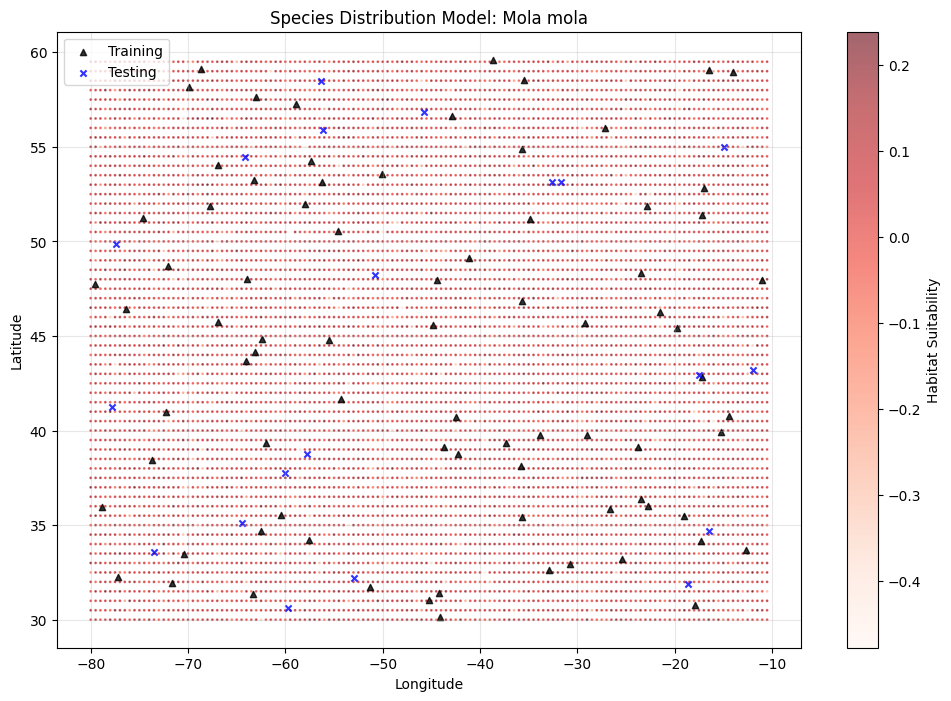

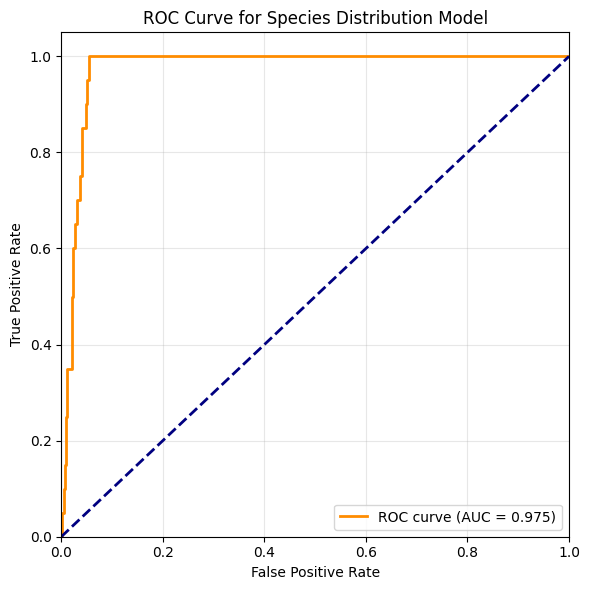

In [10]:
def run_sdm_example():
    """
    Example function showing how to use the MarineSpeciesDistributionModel
    """
    # Sample data creation
    np.random.seed(42)

    # Create sample occurrence data for Mola mola
    n_points = 100
    sample_data = {
        'scientificName': ['Mola mola'] * n_points,
        'decimalLatitude': np.random.uniform(30, 60, n_points),
        'decimalLongitude': np.random.uniform(-80, -10, n_points),
        'salinity': np.random.uniform(32, 36, n_points),
        'temperature': np.random.uniform(10, 25, n_points)
    }

    df = pd.DataFrame(sample_data)

    # Initialize  SDM
    sdm = MarineSpeciesDistributionModel(nu=0.1, kernel='rbf', gamma=0.5)
    sdm.species_name = 'Mola mola'

    # Prepare the data
    environmental_cols = ['salinity', 'temperature']
    data = sdm.prepare_data(df, environmental_cols)

    # Fit the model
    sdm.fit(data['X_train'])

    # Evaluate the model
    auc_score, fpr, tpr = sdm.evaluate_model(data['X_test'])
    print(f"Model AUC Score: {auc_score:.3f}")

    # Create prediction grid
    grid_resolution = 0.5
    bounds = (-80, 30, -10, 60)

    # Create a simple prediction grid
    lons = np.arange(bounds[0], bounds[2], grid_resolution)
    lats = np.arange(bounds[1], bounds[3], grid_resolution)
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    grid_coords = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])

    # Simulate environmental data for grid
    grid_salinity = np.random.uniform(32, 36, len(grid_coords))
    grid_temperature = np.random.uniform(10, 25, len(grid_coords))

    grid_env = np.column_stack([grid_salinity, grid_temperature])

    # Make predictions
    predictions = sdm.predict(grid_env)

    # Create grid DataFrame
    grid_df = pd.DataFrame({
        'longitude': grid_coords[:, 0],
        'latitude': grid_coords[:, 1],
        'salinity': grid_salinity,
        'temperature': grid_temperature,
        'suitability': predictions
    })

    # Plot the results
    fig = sdm.plot_distribution_map(grid_df, occurrence_data=data)

    # Plot ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Species Distribution Model')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return sdm, grid_df

if __name__ == "__main__":
    model, predictions = run_sdm_example()

SDM for mola mola

Example usage


In [ ]:
def run_mola_mola_sdm(df_with_env, project_dir='.', add_more_variables=True):

    df_final = df_with_env.copy()
    environmental_cols = ['salinity']

    if add_more_variables:


        potential_files = [
            ('temperature.nc', 'temperature'),
            ('sst.nc', 'sea_surface_temperature'),
            ('depth.nc', 'depth'),
            ('bathymetry.nc', 'bathymetry'),
            ('chlorophyll.nc', 'chlorophyll'),
            ('oxygen.nc', 'oxygen'),
            ('current_speed.nc', 'current_speed')
        ]

        for filename, var_name in potential_files:
            try:
                raster_path = f'{project_dir}/{filename}'
                df_final = add_environmental_data(df_final, raster_path, var_name)
                environmental_cols.append(var_name)

            except Exception as e:
                print(f" Could not add {var_name}: file not found or error")
                continue

    print("\n Preparing data for modeling...")

    df_clean = df_final.dropna(subset=environmental_cols)
    print(f" Clean records: {len(df_clean)}/{len(df_final)} ({len(df_clean)/len(df_final)*100:.1f}%)")

    # if len(df_clean) < 20:
    #     print(" Error: Too few records with complete environmental data!")
    #     return None


    X = df_clean[environmental_cols].values
    coords = df_clean[['decimalLatitude', 'decimalLongitude']].values

    # Split into train/test
    X_train, X_test, coords_train, coords_test = train_test_split(
        X, coords, test_size=0.2, random_state=42
    )

    print(f" Training samples: {len(X_train)}")
    print(f" Testing samples: {len(X_test)}")


    print("\n Environmental Data Summary:")
    for i, col in enumerate(environmental_cols):
        data = df_clean[col]
        print(f"  {col}: {data.min():.2f} - {data.max():.2f} (mean: {data.mean():.2f})")

    print("\n Training One-Class SVM model...")


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)


    model = svm.OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')
    model.fit(X_train_scaled)

    print("Model training completed!")

    print("\n Evaluating model performance...")


    X_test_scaled = scaler.transform(X_test)
    test_predictions = model.decision_function(X_test_scaled)

    n_background = 1000
    feature_mins = X_train.min(axis=0)
    feature_maxs = X_train.max(axis=0)

    background_points = np.random.uniform(
        low=feature_mins,
        high=feature_maxs,
        size=(n_background, len(environmental_cols))
    )

    background_scaled = scaler.transform(background_points)
    background_predictions = model.decision_function(background_scaled)


    y_true = np.concatenate([np.ones(len(test_predictions)), np.zeros(len(background_predictions))])
    y_scores = np.concatenate([test_predictions, background_predictions])

    fpr, tpr, _ = metrics.roc_curve(y_true, y_scores)
    auc_score = metrics.auc(fpr, tpr)

    print(f" AUC Score: {auc_score:.3f}")


    print("\n Creating habitat suitability predictions...")

    X_all_scaled = scaler.transform(X)
    all_predictions = model.decision_function(X_all_scaled)

    df_results = df_clean.copy()
    df_results['habitat_suitability'] = all_predictions

    print(f" Suitability range: {all_predictions.min():.3f} to {all_predictions.max():.3f}")


    print("\n Creating visualizations...")

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Mola mola SDM')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(
        df_results['decimalLongitude'],
        df_results['decimalLatitude'],
        c=df_results['habitat_suitability'],
        cmap='RdYlBu_r',
        s=30,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    plt.colorbar(scatter, label='Habitat Suitability')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Mola mola - Habitat Suitability')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    print("\n ANALYSIS SUMMARY")

    print(f" Species: Mola mola")
    print(f" Total records: {len(df_with_env)}")
    print(f" Records used: {len(df_clean)}")
    print(f" Environmental variables: {len(environmental_cols)}")
    print(f" Model performance (AUC): {auc_score:.3f}")

    if auc_score > 0.7:
        print(" Good model performance!")
    elif auc_score > 0.6:
        print("  Moderate model performance")
    else:
        print(" Poor model performance - consider adding more environmental variables")


    print(f"\n TOP 5 MOST SUITABLE LOCATIONS:")
    top_locations = df_results.nlargest(5, 'habitat_suitability')
    for i, (idx, row) in enumerate(top_locations.iterrows(), 1):
        print(f"  {i}. Lat: {row['decimalLatitude']:.3f}, Lon: {row['decimalLongitude']:.3f}, "
              f"Suitability: {row['habitat_suitability']:.3f}")

    print(f"\n BOTTOM 5 LEAST SUITABLE LOCATIONS:")
    bottom_locations = df_results.nsmallest(5, 'habitat_suitability')
    for i, (idx, row) in enumerate(bottom_locations.iterrows(), 1):
        print(f"  {i}. Lat: {row['decimalLatitude']:.3f}, Lon: {row['decimalLongitude']:.3f}, "
              f"Suitability: {row['habitat_suitability']:.3f}")


    results = {
        'model': model,
        'scaler': scaler,
        'predictions': df_results,
        'auc_score': auc_score,
        'environmental_cols': environmental_cols,
        'train_data': X_train,
        'test_data': X_test,
        'train_coords': coords_train,
        'test_coords': coords_test,
        'fpr': fpr,
        'tpr': tpr
    }



    return results


Usage


 Preparing data for modeling...
 Clean records: 12660/12777 (99.1%)
 Training samples: 10128
 Testing samples: 2532

 Environmental Data Summary:
  salinity: 23.81 - 38.50 (mean: 32.72)

 Training One-Class SVM model...
Model training completed!

 Evaluating model performance...
 AUC Score: 0.766

 Creating habitat suitability predictions...
 Suitability range: -293.941 to 4.477

 Creating visualizations...


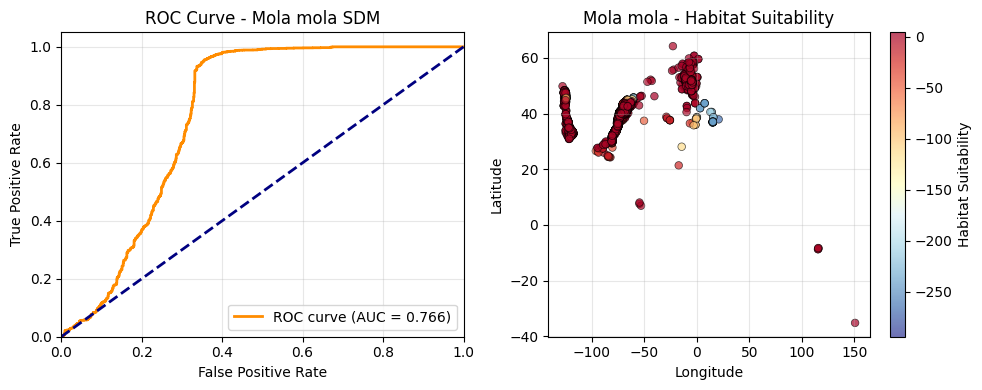


 ANALYSIS SUMMARY
 Species: Mola mola
 Total records: 12777
 Records used: 12660
 Environmental variables: 1
 Model performance (AUC): 0.766
 Good model performance!

 TOP 5 MOST SUITABLE LOCATIONS:
  1. Lat: 51.091, Lon: -9.951, Suitability: 4.477
  2. Lat: 57.918, Lon: -13.502, Suitability: 4.477
  3. Lat: 34.123, Lon: -77.552, Suitability: 4.476
  4. Lat: 34.072, Lon: -77.620, Suitability: 4.476
  5. Lat: 32.264, Lon: -79.852, Suitability: 4.476

 BOTTOM 5 LEAST SUITABLE LOCATIONS:
  1. Lat: 37.250, Lon: -75.717, Suitability: -293.941
  2. Lat: 37.208, Lon: -75.713, Suitability: -293.048
  3. Lat: 36.329, Lon: -75.812, Suitability: -273.837
  4. Lat: 37.916, Lon: 20.865, Suitability: -266.281
  5. Lat: 46.605, Lon: -124.194, Suitability: -260.780
Analysis completed!
 AUC Score: 0.766


In [ ]:
def example_basic_usage(df_with_env, project_dir):
    """
    Basic example - just run with salinity data
    """

    results = run_mola_mola_sdm(df_with_env, project_dir, add_more_variables=False)

    if results:
        print("Analysis completed!")
        print(f" AUC Score: {results['auc_score']:.3f}")
        return results
    else:
        print("Analysis failed!")
        return None

if __name__ == "__main__":
   example_basic_usage(df_with_env=df_with_env,project_dir=project_dir)